In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid', {'axes.facecolor': '.9'})
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')
%matplotlib inline

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [3]:
# Set random state. 
rs = np.random.seed(25)

def generate_circle_sample_data(r, n, sigma):
    """Generate circle data with random Gaussian noise."""
    angles = np.random.uniform(low=0, high=2*np.pi, size=n)

    x_epsilon = np.random.normal(loc=0.0, scale=sigma, size=n)
    y_epsilon = np.random.normal(loc=0.0, scale=sigma, size=n)

    x = r*np.cos(angles) + x_epsilon
    y = r*np.sin(angles) + y_epsilon
    return x, y


def generate_concentric_circles_data(param_list):
    """Generates many circle data with random Gaussian noise."""
    coordinates = [ 
        generate_circle_sample_data(param[0], param[1], param[2])
     for param in param_list
    ]
    return coordinates

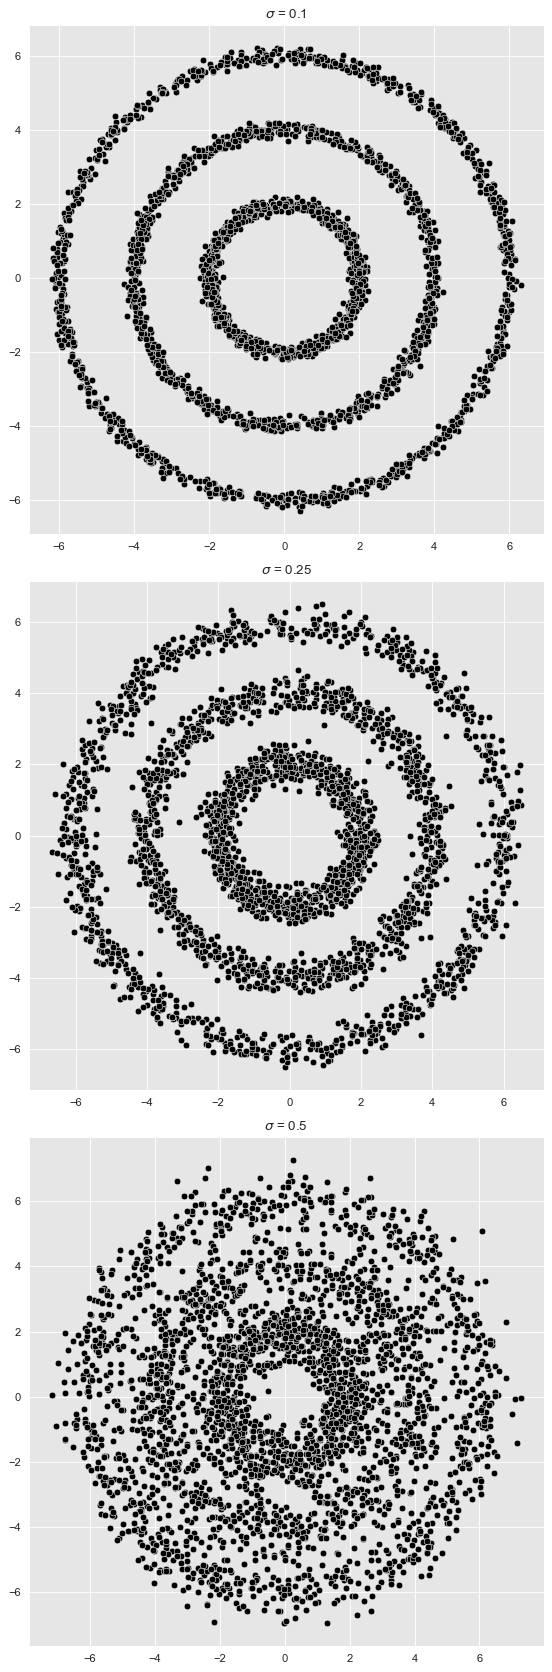

In [4]:
# Set global plot parameters. 
plt.rcParams['figure.figsize'] = [8, 8]
plt.rcParams['figure.dpi'] = 80

# Number of points per circle. 
n = 1000
# Radius. 
r_list =[2, 4, 6]
# Standar deviation (Gaussian noise). 
sigmas = [0.1, 0.25, 0.5]

param_lists = [[(r, n, sigma) for r in r_list] for sigma in sigmas] 
# We store the data on this list.
coordinates_list = []

fig, axes = plt.subplots(3, 1, figsize=(7, 21))

for i, param_list in enumerate(param_lists):

    coordinates = generate_concentric_circles_data(param_list)

    coordinates_list.append(coordinates)
    
    ax = axes[i]
    
    for j in range(0, len(coordinates)):
    
        x, y = coordinates[j]
        sns.scatterplot(x=x, y=y, color='black', ax=ax)
        ax.set(title=f'$\sigma$ = {param_list[0][2]}')

plt.tight_layout()

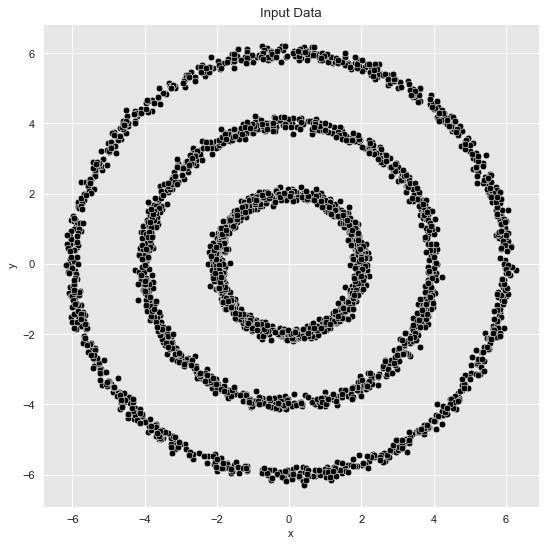

In [5]:
from itertools import chain

coordinates = coordinates_list[0]

def data_frame_from_coordinates(coordinates): 
    """From coordinates to data frame."""
    xs = chain(*[c[0] for c in coordinates])
    ys = chain(*[c[1] for c in coordinates])

    return pd.DataFrame(data={'x': xs, 'y': ys})

data_df = data_frame_from_coordinates(coordinates)

# Plot the input data.
fig, ax = plt.subplots()
sns.scatterplot(x='x', y='y', color='black', data=data_df, ax=ax)
ax.set(title='Input Data');

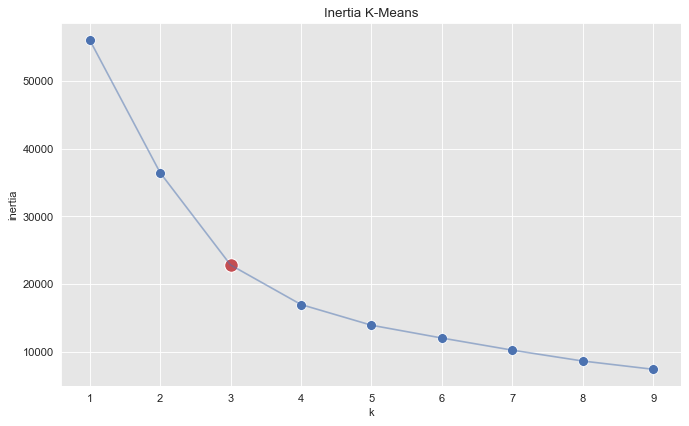

In [6]:
from sklearn.cluster import KMeans

inertias = []

k_candidates = range(1, 10)

for k in k_candidates:
    k_means = KMeans(random_state=42, n_clusters=k)
    k_means.fit(data_df)
    inertias.append(k_means.inertia_)

fig, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(x=k_candidates, y = inertias, s=80, ax=ax)
sns.scatterplot(x=[k_candidates[2]], y = [inertias[2]], color=sns_c[3], s=150, ax=ax)
sns.lineplot(x=k_candidates, y = inertias, alpha=0.5, ax=ax)
ax.set(title='Inertia K-Means', ylabel='inertia', xlabel='k');

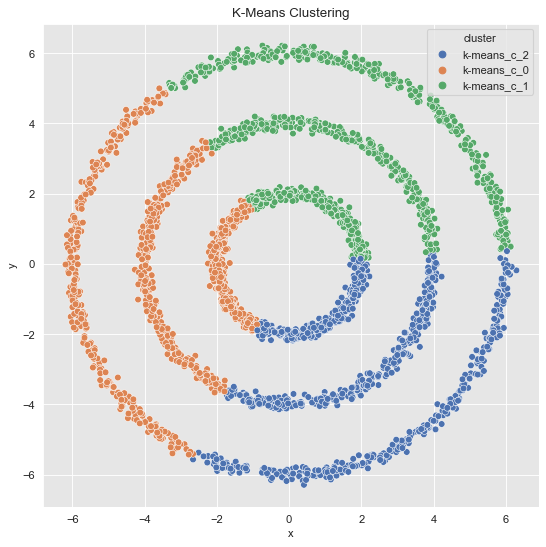

In [7]:
k_means = KMeans(random_state=25, n_clusters=3)
k_means.fit(data_df)
cluster = k_means.predict(data_df)

cluster = ['k-means_c_' + str(c) for c in cluster]

fig, ax = plt.subplots()
sns.scatterplot(x='x', y='y', data=data_df.assign(cluster = cluster), hue='cluster', ax=ax)
ax.set(title='K-Means Clustering');

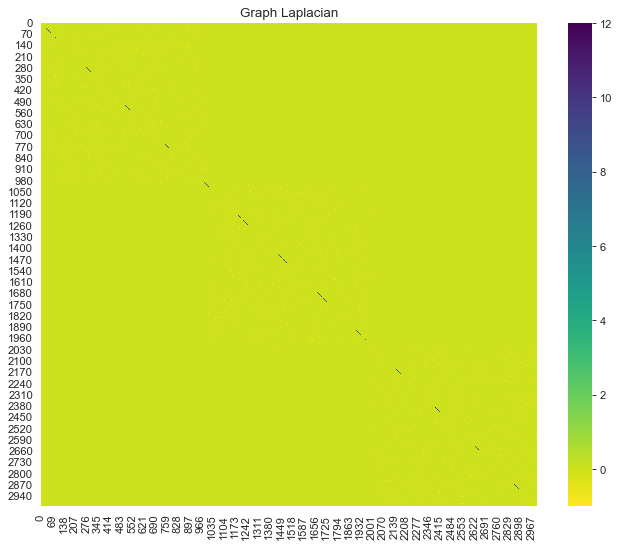

In [8]:
from sklearn.neighbors import kneighbors_graph
from scipy import sparse

def generate_graph_laplacian(df, nn):
    """Generate graph Laplacian from data."""
    # Adjacency Matrix.
    connectivity = kneighbors_graph(X=df, n_neighbors=nn, mode='connectivity')
    adjacency_matrix_s = (1/2)*(connectivity + connectivity.T)
    # Graph Laplacian.
    graph_laplacian_s = sparse.csgraph.laplacian(csgraph=adjacency_matrix_s, normed=False)
    graph_laplacian = graph_laplacian_s.toarray()
    return graph_laplacian 
    
graph_laplacian = generate_graph_laplacian(df=data_df, nn=8)

# Plot the graph Laplacian as heat map.
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(graph_laplacian, ax=ax, cmap='viridis_r')
ax.set(title='Graph Laplacian');

In [9]:
from scipy import linalg

eigenvals, eigenvcts = linalg.eig(graph_laplacian)

In [10]:
np.unique(np.imag(eigenvals))



array([0.])

In [11]:

# We project onto the real numbers. 
def compute_spectrum_graph_laplacian(graph_laplacian):
    """Compute eigenvalues and eigenvectors and project 
    them onto the real numbers.
    """
    eigenvals, eigenvcts = linalg.eig(graph_laplacian)
    eigenvals = np.real(eigenvals)
    eigenvcts = np.real(eigenvcts)
    return eigenvals, eigenvcts

eigenvals, eigenvcts = compute_spectrum_graph_laplacian(graph_laplacian)



In [12]:

eigenvcts_norms = np.apply_along_axis(
  lambda v: np.linalg.norm(v, ord=2), 
  axis=0, 
  arr=eigenvcts
)

print('Min Norm: ' + str(eigenvcts_norms.min()))
print('Max Norm: ' + str(eigenvcts_norms.max()))

Min Norm: 0.9999999999999996
Max Norm: 1.0000000000000007


In [13]:
eigenvals_sorted_indices = np.argsort(eigenvals)
eigenvals_sorted = eigenvals[eigenvals_sorted_indices]

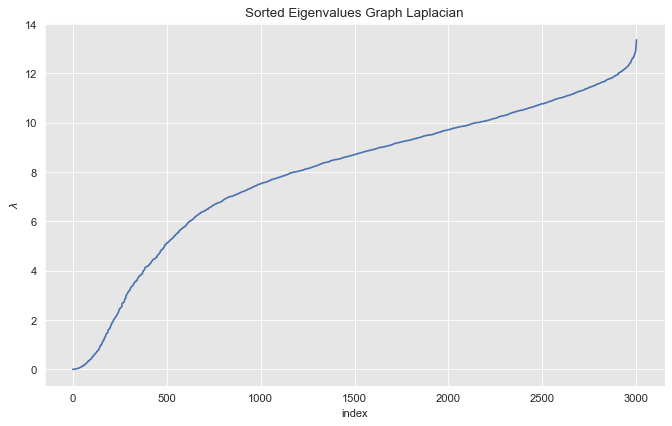

In [14]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(x=range(1, eigenvals_sorted_indices.size + 1), y=eigenvals_sorted, ax=ax)
ax.set(title='Sorted Eigenvalues Graph Laplacian', xlabel='index', ylabel=r'$\lambda$');

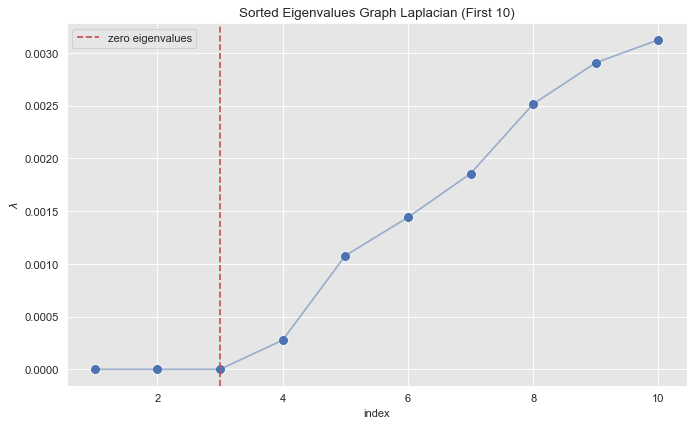

In [15]:
index_lim = 10

fig, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(x=range(1, eigenvals_sorted_indices[: index_lim].size + 1), y=eigenvals_sorted[: index_lim], s=80, ax=ax)
sns.lineplot(x=range(1, eigenvals_sorted_indices[: index_lim].size + 1), y=eigenvals_sorted[: index_lim], alpha=0.5, ax=ax)
ax.axvline(x=3, color=sns_c[3], label='zero eigenvalues', linestyle='--')
ax.legend()
ax.set(title=f'Sorted Eigenvalues Graph Laplacian (First {index_lim})', xlabel='index', ylabel=r'$\lambda$');

In [16]:
zero_eigenvals_index = np.argwhere(abs(eigenvals) < 1e-5)
eigenvals[zero_eigenvals_index]

array([[-9.71878827e-16],
       [ 5.52509427e-16],
       [ 1.37353314e-15]])

In [17]:
proj_df = pd.DataFrame(eigenvcts[:, zero_eigenvals_index.squeeze()])
proj_df.columns = ['v_' + str(c) for c in proj_df.columns]
proj_df.head()

,v_0,v_1,v_2
0,-0.031623,0.0,0.0
1,-0.031623,0.0,0.0
2,-0.031623,0.0,0.0
3,-0.031623,0.0,0.0
4,-0.031623,0.0,0.0


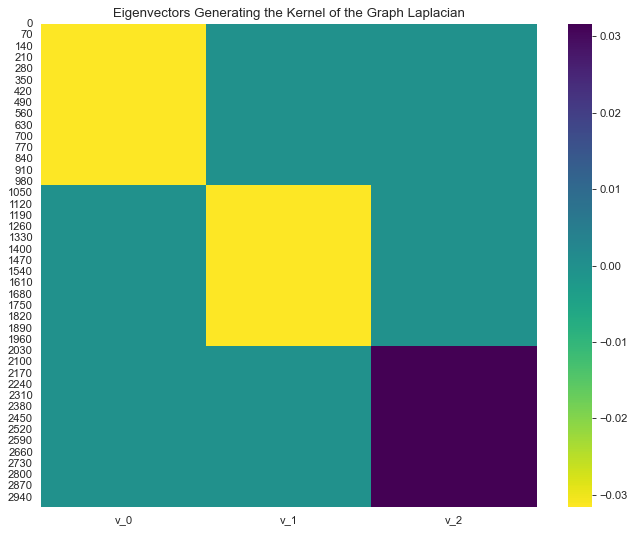

In [18]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(proj_df, ax=ax, cmap='viridis_r')
ax.set(title='Eigenvectors Generating the Kernel of the Graph Laplacian');

In [19]:
def project_and_transpose(eigenvals, eigenvcts, num_ev):
    """Select the eigenvectors corresponding to the first 
    (sorted) num_ev eigenvalues as columns in a data frame.
    """
    eigenvals_sorted_indices = np.argsort(eigenvals)
    indices = eigenvals_sorted_indices[: num_ev]

    proj_df = pd.DataFrame(eigenvcts[:, indices.squeeze()])
    proj_df.columns = ['v_' + str(c) for c in proj_df.columns]
    return proj_df

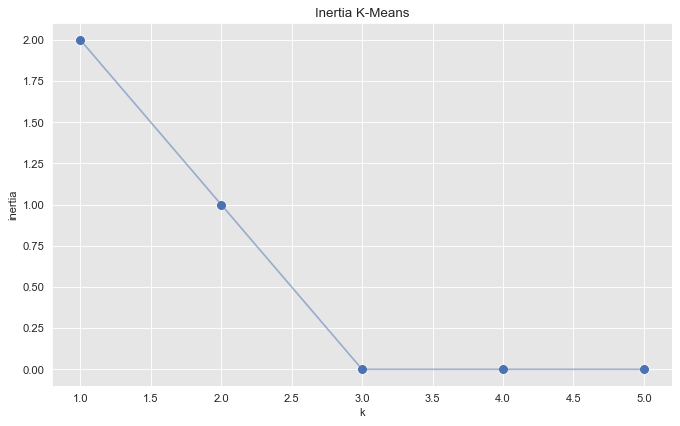

In [20]:
inertias = []

k_candidates = range(1, 6)

for k in k_candidates:
    k_means = KMeans(random_state=42, n_clusters=k)
    k_means.fit(proj_df)
    inertias.append(k_means.inertia_)
fig, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(x=k_candidates, y = inertias, s=80, ax=ax)
sns.lineplot(x=k_candidates, y = inertias, alpha=0.5, ax=ax)
ax.set(title='Inertia K-Means', ylabel='inertia', xlabel='k');

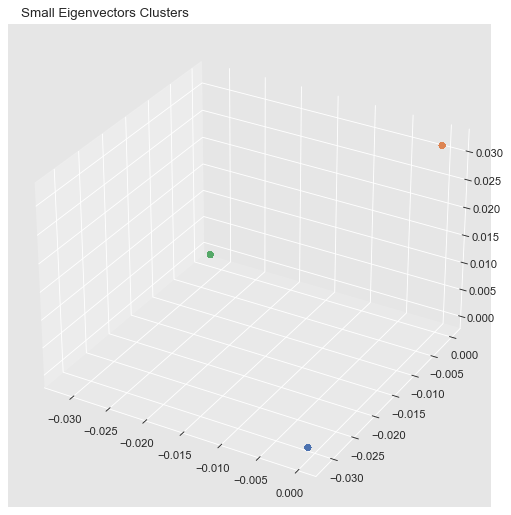

In [21]:
def run_k_means(df, n_clusters):
    """K-means clustering."""
    k_means = KMeans(random_state=25, n_clusters=n_clusters)
    k_means.fit(df)
    cluster = k_means.predict(df)
    return cluster

cluster = run_k_means(proj_df, n_clusters=3)
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(
    xs=proj_df['v_0'], 
    ys=proj_df['v_1'], 
    zs=proj_df['v_2'],
    c=[{0: sns_c[0], 1: sns_c[1], 2: sns_c[2]}.get(c) for c in cluster]
)
ax.set_title('Small Eigenvectors Clusters', x=0.2);

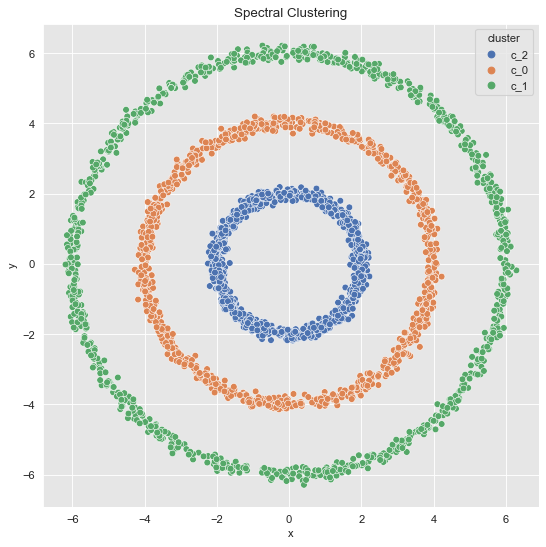

In [22]:
data_df['cluster'] = ['c_' + str(c) for c in cluster]

fig, ax = plt.subplots()
sns.scatterplot(x='x', y='y', data=data_df, hue='cluster', ax=ax)
ax.set(title='Spectral Clustering');

In [23]:
def spectral_clustering(df, n_neighbors, n_clusters):
    """Spectral Clustering Algorithm."""
    graph_laplacian = generate_graph_laplacian(df, n_neighbors)
    eigenvals, eigenvcts = compute_spectrum_graph_laplacian(graph_laplacian)
    proj_df = project_and_transpose(eigenvals, eigenvcts, n_clusters)
    cluster = run_k_means(proj_df, proj_df.columns.size)
    return ['c_' + str(c) for c in cluster]

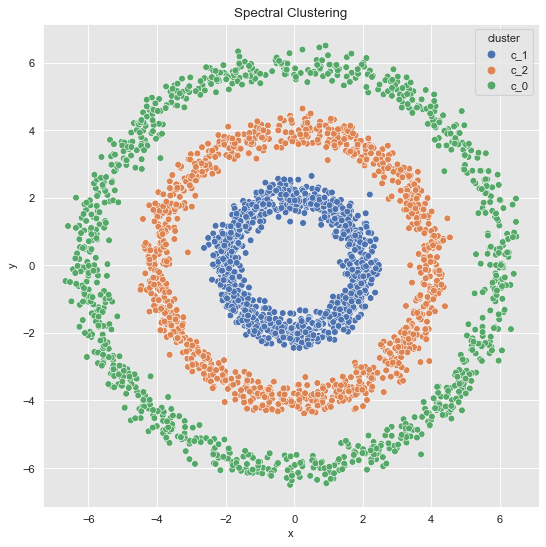

In [24]:
data_df = data_frame_from_coordinates(coordinates_list[1])
data_df['cluster'] = spectral_clustering(df=data_df, n_neighbors=8, n_clusters=3)

fig, ax = plt.subplots()
sns.scatterplot(x='x', y='y', data=data_df, hue='cluster', ax=ax)
ax.set(title='Spectral Clustering');

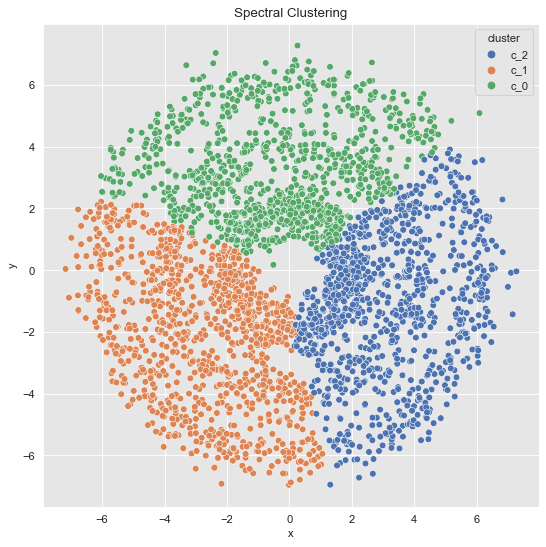

In [25]:
data_df = data_frame_from_coordinates(coordinates_list[2])
data_df['cluster'] = spectral_clustering(df=data_df, n_neighbors=8, n_clusters=3)

fig, ax = plt.subplots()
sns.scatterplot(x='x', y='y', data=data_df, hue='cluster', ax=ax)
ax.set(title='Spectral Clustering');